In [1]:
# Set spark environments
import os
import sys
#os.environ["SPARK_HOME"] = '/home/ypang6/anaconda3/lib/python3.7/site-packages/pyspark'
#os.environ["PYTHONPATH"] = '/home/ypang6/anaconda3/bin/python3.7'
#os.environ['PYSPARK_PYTHON'] = '/home/ypang6/anaconda3/bin/python3.7'
#os.environ['PYSPARK_DRIVER_PYTHON'] = '/home/ypang6/anaconda3/bin/python3.7'
os.environ["SPARK_HOME"]="/usr/local/spark"
os.environ["PYLIB"]=os.environ["SPARK_HOME"]+"/python/lib"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.9-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")
os.environ["PYSPARK_PYTHON"] = "/home/anaconda3/bin/python" 
os.environ["PYSPARK_SUBMIT_ARGS"] = "--master local[2] pyspark-shell "

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
#####
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql import Window
#####

In [3]:
spark = SparkSession \
        .builder \
        .appName("Terminal_Area_Flight_Data_Query") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

# recType3 Data
## Custom schema of the data
### References to IFF_2.15_Specs_Sherlock.doc

In [4]:
myschema = StructType([
    StructField("recType", ShortType(), True),  #1  //track point record type number
    StructField("recTime", StringType(), True),  #2  //seconds since midnigght 1/1/70 UTC
    StructField("fltKey", LongType(), True),  #3  //flight key
    StructField("bcnCode", IntegerType(), True),  #4  //digit range from 0 to 7
    StructField("cid", IntegerType(), True),  #5  //computer flight id
    StructField("Source", StringType(), True),  #6  //source of the record 
    StructField("msgType", StringType(), True),  #7
    StructField("acId", StringType(), True),  #8  //call sign
    StructField("recTypeCat", StringType(), True),  #9
    StructField("lat", DoubleType(), True),  #10
    StructField("lon", DoubleType(), True),  #11 
    StructField("alt", DoubleType(), True),  #12  //in 100s of feet
    StructField("significance", ShortType(), True),  #13 //digit range from 1 to 10
    StructField("latAcc", DoubleType(), True),  #14
    StructField("lonAcc", DoubleType(), True),  #15
    StructField("altAcc", DoubleType(), True),  #16
    StructField("groundSpeed", IntegerType(), True),  #17 //in knots
    StructField("course", DoubleType(), True),  #18  //in degrees from true north
    StructField("rateOfClimb", DoubleType(), True),  #19  //in feet per minute
    StructField("altQualifier", StringType(), True),  #20  //Altitude qualifier (the “B4 character”)
    StructField("altIndicator", StringType(), True),  #21  //Altitude indicator (the “C4 character”)
    StructField("trackPtStatus", StringType(), True),  #22  //Track point status (e.g., ‘C’ for coast)
    StructField("leaderDir", IntegerType(), True),  #23  //int 0-8 representing the direction of the leader line
    StructField("scratchPad", StringType(), True),  #24
    StructField("msawInhibitInd", ShortType(), True),  #25 // MSAW Inhibit Indicator (0=not inhibited, 1=inhibited)
    StructField("assignedAltString", StringType(), True),  #26 
    StructField("controllingFac", StringType(), True),  #27
    StructField("controllingSec", StringType(), True),  #28
    StructField("receivingFac", StringType(), True),  #29
    StructField("receivingSec", StringType(), True),  #30
    StructField("activeContr", IntegerType(), True),  #31  // the active control number
    StructField("primaryContr", IntegerType(), True),  #32  //The primary(previous, controlling, or possible next)controller number
    StructField("kybrdSubset", StringType(), True),  #33  //identifies a subset of controller keyboards
    StructField("kybrdSymbol", StringType(), True),  #34  //identifies a keyboard within the keyboard subsets
    StructField("adsCode", IntegerType(), True),  #35  //arrival departure status code
    StructField("opsType", StringType(), True),  #36  //Operations type (O/E/A/D/I/U)from ARTS and ARTS 3A data
    StructField("airportCode", StringType(), True),  #37 
    StructField("trackNumber", IntegerType(), True),  #38
    StructField("tptReturnType", StringType(), True),  #39
    StructField("modeSCode", StringType(), True),  #40
    StructField("sensorTrackNumberList", StringType(), True), #41 //a list of sensor/track number combinations
    StructField("spi", StringType(), True),  #42 // representing the Ident feature
    StructField("dvs", StringType(), True), #43 // indicate the aircraft is within a suppresion volumn area
    StructField("dupM3a", StringType(), True),  #44 // indicate 2 aircraft have the same mode 3a code
    StructField("tid", StringType(), True),  #45 //Aircraft Ident entered by pilot

])

In [5]:
date = 20190801

In [6]:
import glob
file_path = glob.glob("/home/pzhao28/Documents/Research/Software/sequencing and deconflict/arrival_time_prediction/PySparkGeoSparkDemo-main/data")[0]

In [7]:
df = spark.read.csv(file_path, header=False, sep=",", schema=myschema)

In [8]:
df.printSchema()

root
 |-- recType: short (nullable = true)
 |-- recTime: string (nullable = true)
 |-- fltKey: long (nullable = true)
 |-- bcnCode: integer (nullable = true)
 |-- cid: integer (nullable = true)
 |-- Source: string (nullable = true)
 |-- msgType: string (nullable = true)
 |-- acId: string (nullable = true)
 |-- recTypeCat: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- alt: double (nullable = true)
 |-- significance: short (nullable = true)
 |-- latAcc: double (nullable = true)
 |-- lonAcc: double (nullable = true)
 |-- altAcc: double (nullable = true)
 |-- groundSpeed: integer (nullable = true)
 |-- course: double (nullable = true)
 |-- rateOfClimb: double (nullable = true)
 |-- altQualifier: string (nullable = true)
 |-- altIndicator: string (nullable = true)
 |-- trackPtStatus: string (nullable = true)
 |-- leaderDir: integer (nullable = true)
 |-- scratchPad: string (nullable = true)
 |-- msawInhibitInd: short (nullable = true)
 |

### Select Columns

In [9]:
cols = ['recType', 'recTime', 'acId', 'lat', 'lon', 'alt', 'groundSpeed']
df_rec3 = df.select(*cols).filter(df['recType']==3).withColumn("recTime", df['recTime'].cast(IntegerType()))

In [10]:
df_rec3.show()

+-------+----------+-----+--------+---------+----+-----------+
|recType|   recTime| acId|     lat|      lon| alt|groundSpeed|
+-------+----------+-----+--------+---------+----+-----------+
|      3|1564634988|SKQ74|36.10444|-79.43917|23.0|        200|
|      3|1564634999|SKQ74|36.11417|-79.43611|26.0|        200|
|      3|1564635012|SKQ74|36.12389| -79.4325|29.0|        171|
|      3|1564635024|SKQ74|36.13333|-79.42889|32.0|        180|
|      3|1564635036|SKQ74|36.14278|-79.42583|37.0|        178|
|      3|1564635048|SKQ74| 36.1525|-79.42278|40.0|        183|
|      3|1564635059|SKQ74|36.16083|   -79.42|43.0|        172|
|      3|1564635072|SKQ74|36.17139|-79.41667|46.0|        184|
|      3|1564635084|SKQ74|36.18056|-79.41389|48.0|        172|
|      3|1564635096|SKQ74|36.19028|-79.41056|51.0|        184|
|      3|1564635108|SKQ74|    36.2|-79.40722|54.0|        184|
|      3|1564635120|SKQ74|   36.21|-79.40389|58.0|        189|
|      3|1564635132|SKQ74|36.21944|-79.40056|60.0|     

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

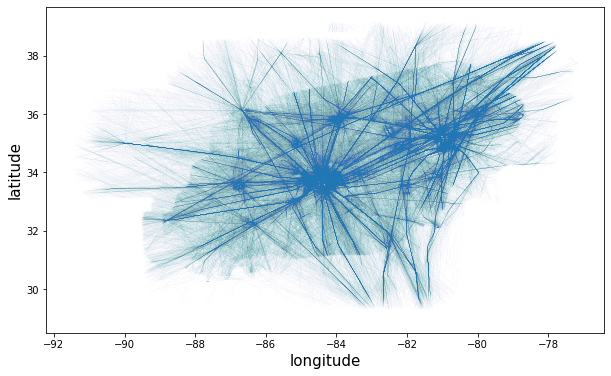

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
pdf_rec3 = df_rec3.toPandas()
plt.scatter(pdf_rec3['lon'], pdf_rec3['lat'],  s=0.00001)
plt.xlabel('longitude',fontsize=15)
plt.ylabel('latitude',fontsize=15)
fig.savefig('sector')

# recType2 data

In [13]:
from pkg_resources.extern import packaging

def parse_version(v):
    try:
        return packaging.version.Version(v)
    except packaging.version.InvalidVersion:
        return packaging.version.LegacyVersion(v)

In [14]:
def read_iff_file(filename, record_types=3, callsigns=None, chunksize=50000, encoding='latin-1'):
    """
    Read IFF file and return data frames for requested record types
    
    From IFF 2.15 specification, record types include:
    2. header
    3. track point
    4. flight plan
    5. data source program
    6. sectorization
    7. minimum safe altitude
    8. flight progress
    9. aircraft state
    Parameters
    ----------
    filename : str
        File to read
    record_types : int, sequence of ints, or 'all'
        Record types to return
    callsigns : None, string, or list of strings
        If None, return records for all aircraft callsigns.
        Otherwise, only return records that match the given callsign
        (in the case of a single string) or match one of the specified
        callsigns (in the case of a list of strings).
    chunksize: int
        Number of rows that are read at a time by pd.read_csv.  This
        limits memory usage when working with large files, as we can
        extract out the desired rows from each chunk, intead of
        reading everything into one large DataFrame and then taking a
        subset.
    encoding: str
        Encoding argument passed on to open and pd.read_csv.  Using
        'latin-1' instead of the default will suppress errors that
        might otherwise occur with minor data corruption.  See
        http://python-notes.curiousefficiency.org/en/latest/python3/text_file_processing.html
    
    Returns
    -------
    DataFrame or dict of DataFrames
       If record_types is a scalar, return a DataFrame containing the
       data for that record type only.  Otherwise, return a dictionary
       mapping each requested record type to a corresponding DataFrame.
    """
    # Note default record_type of 3 (track point) is used for
    # consistency with the behavior of other functions that expect
    # flight tracking data

    # Determine file format version.  This is in record type 1, which
    # for now we assume to occur on the first line.
    with open(filename, 'r') as f:
        version = parse_version(f.readline().split(',')[2])

    # Columns for each record type, from version 2.6 specification.
    cols = {0:['recType','comment'],
            1:['recType','fileType','fileFormatVersion'],
            2:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','acType','Orig','Dest','opsType','estOrig','estDest'],
            3:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','coord1','coord2','alt','significance','coord1Accur','coord2Accur','altAccur','groundSpeed','course','rateOfClimb','altQualifier','altIndicator','trackPtStatus','leaderDir','scratchPad','msawInhibitInd','assignedAltString','controllingFac','controllingSeg','receivingFac','receivingSec','activeContr','primaryContr','kybrdSubset','kybrdSymbol','adsCode','opsType','airportCode'],
            4:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','acType','Orig','Dest','altcode','alt','maxAlt','assignedAltString','requestedAltString','route','estTime','fltCat','perfCat','opsType','equipList','coordinationTime','coordinationTimeType','leaderDir','scratchPad1','scratchPad2','fixPairScratchPad','prefDepArrRoute','prefDepRoute','prefArrRoute'],
            5:['recType','dataSource','programName','programVersion'],
            6:['recType','recTime','Source','msgType','rectypeCat','sectorizationString'],
            7:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','coord1','coord2','alt','significance','coord1Accur','coord2Accur','altAccur','msawtype','msawTimeCat','msawLocCat','msawMinSafeAlt','msawIndex1','msawIndex2','msawVolID'],
            8:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','acType','Orig','Dest','depTime','depTimeType','arrTime','arrTimeType'],
            9:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','coord1','coord2','alt','pitchAngle','trueHeading','rollAngle','trueAirSpeed','fltPhaseIndicator'],
            10:['recType','recTime','fltKey','bcnCode','cid','Source','msgType','AcId','recTypeCat','configType','configSpec']}

    # For newer versions, additional columns are supported.  However,
    # this code could be commented out, and it should still be
    # compatible with newer versions, but just ignoring the additional
    # columns.
    if version >= parse_version('2.13'):
        cols[2] += ['modeSCode']
        cols[3] += ['trackNumber','tptReturnType','modeSCode']
        cols[4] += ['coordinationPoint','coordinationPointType','trackNumber','modeSCode']
    if version >= parse_version('2.15'):
        cols[3] += ['sensorTrackNumberList','spi','dvs','dupM3a','tid']

    # Determine the record type of each row
    with open(filename, 'r', encoding=encoding) as f:
        # An alternative, using less memory, would be to directly
        # create skiprows indices for a particular record type, using
        # a comprehension on enumerate(f); however, that would not
        # allow handling multiple record types.
        line_record_types = [int(line.split(',')[0]) for line in f]

    # Determine which record types to retrieve, and whether the result
    # should be a scalar or dict:
    if record_types == 'all':
        record_types = np.unique(line_record_types)
        scalar_result = False
    elif hasattr(record_types, '__getitem__'):
        scalar_result = False
    else:
        record_types = [record_types]
        scalar_result = True

    if callsigns is not None:
        callsigns = list(np.atleast_1d(callsigns))


    data_frames = dict()
    for record_type in record_types:
        # Construct list of rows to skip:
        skiprows = [i for i,lr in enumerate(line_record_types) if lr != record_type]
        
        # Passing usecols is necessary because for some records, the
        # actual data has extraneous empty columns at the end, in which
        # case the data does not seem to get read correctly without
        # usecols
        if callsigns is None:
            df = pd.concat((chunk for chunk in pd.read_csv(filename, header=None, skiprows=skiprows, names=cols[record_type], usecols=cols[record_type], na_values='?', encoding=encoding, chunksize=chunksize, low_memory=False)), ignore_index=True)
        else:
            df = pd.concat((chunk[chunk['AcId'].isin(callsigns)] for chunk in pd.read_csv(filename, header=None, skiprows=skiprows, names=cols[record_type], usecols=cols[record_type], na_values='?', encoding=encoding, chunksize=chunksize, low_memory=False)), ignore_index=True)

        # For consistency with other PARA-ATM data:
        df.rename(columns={'recTime':'time',
                           'AcId':'callsign',
                           'coord1':'latitude',
                           'coord2':'longitude',
                           'alt':'altitude',
                           'rateOfClimb':'rocd',
                           'groundSpeed':'tas',
                           'course':'heading'},
                  inplace=True)

        #if 'time' in df:
            #df['time'] = pd.to_datetime(df['time'], unit='s')
        if 'altitude' in df:
            df['altitude'] *= 100 # Convert 100s ft to ft

        # Store to dict of data frames
        data_frames[record_type] = df

    if scalar_result:
        result = data_frames[record_types[0]]
    else:
        result = data_frames

    return result

In [15]:
file_path

'/home/pzhao28/Documents/Research/Software/sequencing and deconflict/arrival_time_prediction/PySparkGeoSparkDemo-main/data'

In [16]:
file_names = ['/IFF_ZTL_20190801.csv', '/IFF_ZTL_20190802_050043_86336.csv','/IFF_ZTL_20190803_050001_86185.csv']
pd_df_rec2 = pd.DataFrame() 
for file_name in file_names:
    pd_df_rec2_tmp = pd.DataFrame()
    pd_df_rec2_tmp = read_iff_file(file_path+file_name, record_types=2, chunksize = 1e6)
    pd_df_rec2 = pd.concat([pd_df_rec2, pd_df_rec2_tmp])
#pd_df_rec2 = read_iff_file(file_path, record_types=2, chunksize = 1e6)

In [17]:
cols_rec2 = ['recType', 'time', 'callsign', 'acType', 'Orig', 'Dest']
pd_df_2 = pd_df_rec2[['recType', 'time', 'callsign', 'acType', 'Orig', 'Dest']]

In [18]:
#t = pd.to_datetime(1561350792, format='%Y%m%d')

In [19]:
pd_df_2.head()

,recType,time,callsign,acType,Orig,Dest
0,2,1.564635e+09,SKQ74,PC12,KBUY,KIAD
1,2,1.564633e+09,DAL2681,A321,KATL,KRDU
2,2,1.564632e+09,LN441PC,LJ35,OTK337060,KGBG
3,2,1.564632e+09,DAL2690,B752,37.016667/-80.383333,KATL
4,2,1.564632e+09,UPS9603,B752,ATL130032,KSDF


## Event Data

In [20]:
ev_file_path = file_path + '/ZTL_EV'
ev_file_names = ['/EV_ZTL_20190801_050005_86376.csv', '/EV_ZTL_20190802_050005_86385.csv', '/EV_ZTL_20190803_050002_86193.csv']

pdf_ev = pd.DataFrame()
for name in ev_file_names:
    pdf_ev_tmp = pd.DataFrame()
    pdf_ev_tmp = pd.read_csv(ev_file_path + name)
    pdf_ev = pd.concat([pdf_ev, pdf_ev_tmp])

cols = ['tMidnightSecs', 'AcId', 'tEv', 'EvType', 'Lat', 'Lon']
pdf_ev = pdf_ev[cols]
pdf_ev.loc[:,'recTime'] = pdf_ev['tMidnightSecs'] + pdf_ev['tEv']
pdf_ev.drop_duplicates()

,tMidnightSecs,AcId,tEv,EvType,Lat,Lon,recTime
0,1564617600,DAL2710,16635.0,EV_MOF,33.64056,-84.60389,1.564634e+09
1,1564617600,DAL2710,16635.0,EV_INIT,33.64056,-84.60389,1.564634e+09
8,1564617600,DAL2710,16635.0,EV_TRNS,33.64056,-84.60389,1.564634e+09
9,1564617600,DAL2710,16707.0,EV_HOFF,33.56361,-84.61083,1.564634e+09
11,1564617600,DAL2710,16810.0,EV_RRT,33.43288,-84.56827,1.564634e+09
...,...,...,...,...,...,...,...
471614,1564876800,AAL1133,15922.0,EV_HOFF,37.18361,-82.46556,1.564893e+09
471615,1564876800,AAL1133,16308.0,EV_MOF,37.26806,-81.40028,1.564893e+09
471616,1564876800,AAL1133,16308.0,EV_STOH,37.26806,-81.40028,1.564893e+09
471617,1564876800,AAL1133,16308.0,EV_STOP,37.26806,-81.40028,1.564893e+09


# Data Processing

In [21]:
pd.options.display.max_rows = 1000

In [22]:
### pandas
pdf_rec3['next_acId'] = pdf_rec3['acId'].shift(-1)
pdf_rec3['previous_acId'] = pdf_rec3['acId'].shift(1)
pdf_rec3['init_ac'] = pdf_rec3['acId'] != pdf_rec3['previous_acId']
pdf_rec3['end_ac'] = pdf_rec3['acId'] != pdf_rec3['next_acId']
pdf_rec3.drop(columns=['previous_acId', 'next_acId'])

,recType,recTime,acId,lat,lon,alt,groundSpeed,init_ac,end_ac
0,3,1564634988,SKQ74,36.10444,-79.43917,23.0,200,True,False
1,3,1564634999,SKQ74,36.11417,-79.43611,26.0,200,False,False
2,3,1564635012,SKQ74,36.12389,-79.43250,29.0,171,False,False
3,3,1564635024,SKQ74,36.13333,-79.42889,32.0,180,False,False
4,3,1564635036,SKQ74,36.14278,-79.42583,37.0,178,False,False
...,...,...,...,...,...,...,...,...,...
5693552,3,1564893048,AAL1133,37.25778,-81.53500,292.0,494,False,False
5693553,3,1564893060,AAL1133,37.26028,-81.50194,290.0,481,False,False
5693554,3,1564893072,AAL1133,37.26306,-81.46750,288.0,501,False,False
5693555,3,1564893084,AAL1133,37.26556,-81.43389,286.0,489,False,False


In [23]:
### pyspark
Windowspec=Window.orderBy("recType")
df_rec3 = df_rec3.withColumn('prev_acId', F.lag(df_rec3['acId']).over(Windowspec))
df_rec3 = df_rec3.withColumn('next_acId', F.lead(df_rec3['acId']).over(Windowspec))
df_rec3 = df_rec3.withColumn('init_ac', F.when(df_rec3.acId == df_rec3.prev_acId, False).otherwise(True))
df_rec3 = df_rec3.withColumn('end_ac', F.when(df_rec3.acId == df_rec3.next_acId, False).otherwise(True))
df_rec3 = df_rec3.withColumn('index', F.row_number().over(Windowspec))
df_rec3.drop('prev_acId')
cols = ['index','recType', 'recTime', 'acId', 'lat', 'lon', 'alt', 'groundSpeed', 'init_ac', 'end_ac']

In [24]:
ZTL_airports = ['KATL', 'KCHA', 'KGSO', 'KGSP', 'KHKY', 'KHSV']
airportsCoord = {'KATL':(33.6407, -84.4277), \
                 'KCHA':(35.0374, -85.1970), \
                 'KSGO':(36.1044, -79.9352), \
                 'KGSP':(34.8959, -82.2172), \
                 'KHKY':(35.7422, -81.3893), \
                 'KHSV':(34.6403, -86.7757)}

## extract arrival

In [25]:
schema = StructType([
    StructField('time', StringType(), True),
    StructField('hour', StringType(), True),
    StructField('acId', StringType(), True),
    StructField('lat', DoubleType(), True),
    StructField('lon', DoubleType(), True),
    StructField('alt', DoubleType(), True),
    StructField('Dest', StringType(), True),
    StructField('acType', StringType(), True),
    StructField('arr_time', StringType(), True)
    #StructField('time_100', StringType(), True),
    #StructField('time_40', StringType(), True)
])

In [26]:
import numpy as np

def haversine_vectorize(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    m = 6367 * dist * 1000 #6367 for distance in KM for miles use 3958
    return m

In [27]:
circl200 = 370400
out_circl = 370400/2
in_circl = 74080

In [28]:
out_circl

185200.0

In [29]:
def num_ac_ahead(current_time, dest, data = pdf_rec3):
    tmp_data = data.loc[data['recTime'].between(current_time-600, current_time)]
    tmp_data.loc[:,'distance'] = haversine_vectorize(tmp_data['lon'], tmp_data['lat'], airportsCoord[dest][1], airportsCoord[dest][0])
    return len(tmp_data.loc[tmp_data['distance'].between(in_circl, out_circl)]['acId'].unique())

In [30]:
def num_ac_behind(current_time, dest, data = pdf_rec3):
    tmp_data = data.loc[data['recTime'].between(current_time, current_time+600)]
    tmp_data.loc[:,'distance'] = haversine_vectorize(tmp_data['lon'], tmp_data['lat'], airportsCoord[dest][1], airportsCoord[dest][0])
    return len(tmp_data.loc[tmp_data['distance'].between(in_circl, out_circl)]['acId'].unique())

In [31]:
pdf_ev

,tMidnightSecs,AcId,tEv,EvType,Lat,Lon,recTime
0,1564617600,DAL2710,16635.0,EV_MOF,33.64056,-84.60389,1.564634e+09
1,1564617600,DAL2710,16635.0,EV_INIT,33.64056,-84.60389,1.564634e+09
2,1564617600,DAL2710,16635.0,EV_INIT,33.64056,-84.60389,1.564634e+09
3,1564617600,DAL2710,16635.0,EV_INIT,33.64056,-84.60389,1.564634e+09
4,1564617600,DAL2710,16635.0,EV_INIT,33.64056,-84.60389,1.564634e+09
...,...,...,...,...,...,...,...
471620,1564876800,AAL1133,16308.0,EV_STOP,37.26806,-81.40028,1.564893e+09
471621,1564876800,AAL1133,16308.0,EV_STOP,37.26806,-81.40028,1.564893e+09
471622,1564876800,AAL1133,16308.0,EV_STOP,37.26806,-81.40028,1.564893e+09
471623,1564876800,AAL1133,16308.0,EV_STOP,37.26806,-81.40028,1.564893e+09


In [32]:
from IPython.core.debugger import set_trace

In [33]:
### pandas
columns = ['recTime', 'time','hour','acId', 'lat', 'lon', 'alt', 'Dest','distance', 'acType','groundSpeed', 'num_ac_ahead', 'num_ac_behind', 'arr_time', 'time200','time100','time40', 'holding']
pdf3 = pd.DataFrame([], columns=columns)
for index, row in pdf_rec3.iterrows():
    if row['init_ac']:
        init_index = index
        timestamp = row.recTime
    if row.end_ac:
        if row.alt <= 50:
            end_index = index
            tmp_pdf = pdf_rec3.iloc[init_index:end_index+1, :]
            tmp_dest = pd_df_2[pd_df_2['time']==timestamp]['Dest'].to_string(index=False).strip()
            acType = pd_df_2[pd_df_2['time']==timestamp]['acType'].to_string(index=False).strip()
            if tmp_dest in airportsCoord.keys():
                tmp_pdf.loc[:,'Dest'] = tmp_dest
                tmp_pdf.loc[:,'acType'] = acType
                tmp_pdf.loc[:,'dest_lat'] = airportsCoord[tmp_dest][0]
                tmp_pdf.loc[:,'dest_lon'] = airportsCoord[tmp_dest][1]
                tmp_pdf.loc[:,'distance'] = haversine_vectorize(tmp_pdf['lon'], tmp_pdf['lat'], tmp_pdf['dest_lon'], tmp_pdf['dest_lat'])
                #tmp_pdf = tmp_pdf[tmp_pdf['distance'] <= 185200]
                tmp_pdf = tmp_pdf.loc[tmp_pdf['distance'] <= circl200]
                tmp_pdf.loc[:,'time200'] = tmp_pdf.head(1)['recTime'].values
                tmp_pdf_200 = tmp_pdf.loc[tmp_pdf['distance'].between(circl200 - 20000, circl200)]
                #print(tmp_pdf.head(1)['recTime'].values)
                tmp_pdf = tmp_pdf.loc[tmp_pdf['distance'] <= out_circl]
                tmp_pdf = tmp_pdf.loc[tmp_pdf['distance'] >= in_circl]
                tmp_pdf_out = tmp_pdf.loc[tmp_pdf['distance'].between(out_circl - 20000, out_circl)]
                tmp_pdf_in = tmp_pdf.loc[tmp_pdf['distance'].between(in_circl,in_circl + 20000)]
                if not tmp_pdf_in.empty and not tmp_pdf_out.empty and not tmp_pdf_200.empty:
                    tmp_time = pd.to_datetime(tmp_pdf.head(1)['recTime'].values[0]-14400, unit='s')
                    tmp_pdf.loc[:,'time'] = tmp_time
                    #tmp_pdf.loc[:,'time'] = tmp_pdf.head(1)['recTime']
                    tmp_pdf.loc[:,'hour'] = tmp_time.hour
                    in_time = tmp_pdf.head(1)['recTime'].values[0]
                    out_time = tmp_pdf.tail(1)['recTime'].values[0]
                    center_time = tmp_pdf.loc[tmp_pdf['distance'].between(out_circl/2-100000, out_circl/2)].head(1)['recTime'].values[0]
                    tmp_pdf.loc[:,'arr_time'] = out_time - in_time#out_time - center_time #in_time
                    tmp_pdf.loc[:,'time40'] = out_time
                    tmp_pdf.loc[:,'time100'] = in_time
                    first_time = tmp_pdf.head(1)['recTime'].values[0]
                    number_ahead = num_ac_ahead(in_time, tmp_dest)
                    number_behind = num_ac_behind(in_time, tmp_dest)
                    tmp_pdf.loc[:,'num_ac_ahead'] = number_ahead
                    tmp_pdf.loc[:,'num_ac_behind'] = number_behind
                    
                    tmp_pdf.loc[:,'holding'] = 0
                    acId = tmp_pdf.head(1)['acId'].values[0]
                    lat = tmp_pdf.head(1)['lat']
                    lon = tmp_pdf.head(1)['lon']
                    pdf_ev_tmp = pdf_ev[pdf_ev['AcId']==acId]
                    pdf_ev_tmp = pdf_ev_tmp[pdf_ev_tmp['recTime'].between(in_time-3600, in_time+1800)]
                    if not pdf_ev_tmp.empty:
                        if ('EV_LOOP' or 'EV_GOA') in pdf_ev_tmp['EvType'].values:
                            tmp_pdf.loc[:,'holding'] = 1
                                
                    
                    
                    #print('time200:{}'.format(tmp_pdf[tmp_pdf['recTime']==first_time]['time200'].values))
                    #print('\n')
                    #print('time100:{}'.format(tmp_pdf[tmp_pdf['recTime']==first_time]['time100'].values))
                    pdf3 = pdf3.append(tmp_pdf[tmp_pdf['recTime']==first_time][columns])
                    print("processed aircraft: {}".format(pdf3.shape[0]),end='\r')
                    sys.stdout.flush()


/home/pzhao28/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/pzhao28/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [34]:
pdf3[pdf3['holding']==1]

,recTime,time,hour,acId,lat,lon,alt,Dest,distance,acType,groundSpeed,num_ac_ahead,num_ac_behind,arr_time,time200,time100,time40,holding
65543,1564651922,2019-08-01 05:32:02,5,FDX1576,35.02750,-87.20306,230.0,KCHA,182536.155695,B752,457,36,32,476,1564651126,1564651922,1564652398,1
822280,1564678112,2019-08-01 12:48:32,12,NKS565,34.92778,-85.68361,240.0,KATL,183718.871423,A320,506,152,131,458,1564677275,1564678112,1564678570,1
926489,1564680723,2019-08-01 13:32:03,13,DAL2463,34.42861,-86.19694,295.0,KATL,184959.609297,MD88,455,141,134,1255,1564679915,1564680723,1564681978,1
935673,1564680653,2019-08-01 13:30:53,13,SWA237,34.35833,-86.23056,330.0,KATL,184241.162006,B737,441,141,138,1552,1564679855,1564680653,1564682205,1
945031,1564680604,2019-08-01 13:30:04,13,SWA1289,34.39222,-86.19083,310.0,KATL,182610.679950,B738,458,135,137,1938,1564679795,1564680604,1564682542,1
945950,1564680832,2019-08-01 13:33:52,13,DAL2454,34.36472,-86.22722,285.0,KATL,184267.114375,B752,392,142,132,1649,1564680047,1564680832,1564682481,1
958682,1564681044,2019-08-01 13:37:24,13,DPJ26,34.85583,-85.80222,280.0,KATL,184859.818354,CL60,421,134,132,1617,1564680232,1564681044,1564682661,1
969256,1564680904,2019-08-01 13:35:04,13,DAL1044,34.35528,-86.22306,310.0,KATL,183474.312890,B752,452,140,136,2010,1564680119,1564680904,1564682914,1
970284,1564682246,2019-08-01 13:57:26,13,DAL1302,34.86694,-85.75472,270.0,KATL,182820.925684,B712,407,128,137,919,1564680444,1564682246,1564683165,1
972053,1564681852,2019-08-01 13:50:52,13,DAL920,34.35722,-86.21944,310.0,KATL,183265.582716,MD88,461,129,129,1182,1564680551,1564681852,1564683034,1


Text(0, 0.5, 'time spent from 100NM to 40NM \n (second)')

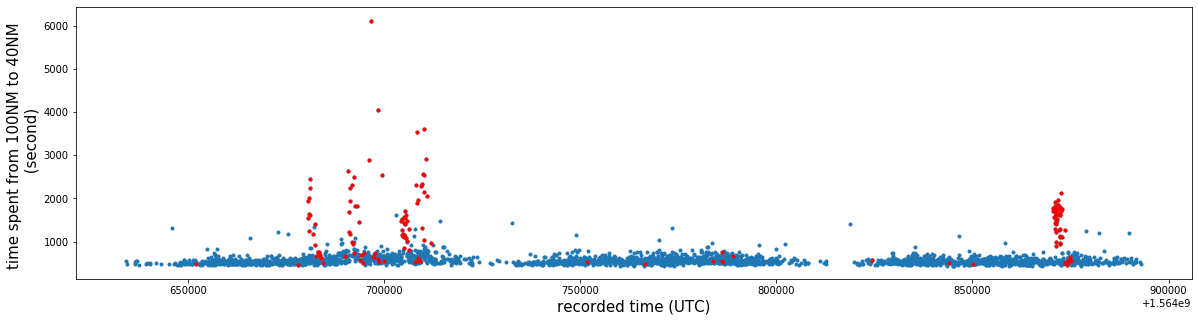

In [35]:
fig, ax = plt.subplots(figsize=(20,5))
arr_t = pdf3['arr_time'].values
time_list = pdf3['recTime'].values
arr_t_holding = pdf3[pdf3['holding']==1]['arr_time'].values
time_list_holding = pdf3[pdf3['holding']==1]['recTime'].values
plt.scatter(time_list, arr_t, marker='.')
plt.scatter(time_list_holding, arr_t_holding, marker='.', color='r')
plt.xlabel('recorded time (UTC)', fontsize=15)
plt.ylabel('time spent from 100NM to 40NM \n (second)', fontsize=15)


In [36]:
import datetime
d = datetime.datetime(2019,8,3)
epoch = datetime.datetime(1970,1,1)
test_init = (d - epoch).total_seconds()+14400

In [37]:
test_data = pdf3[pdf3['recTime'].between(test_init,test_init+90000)]

Text(0, 0.5, 'time spent from 100NM to 40NM \n (second)')

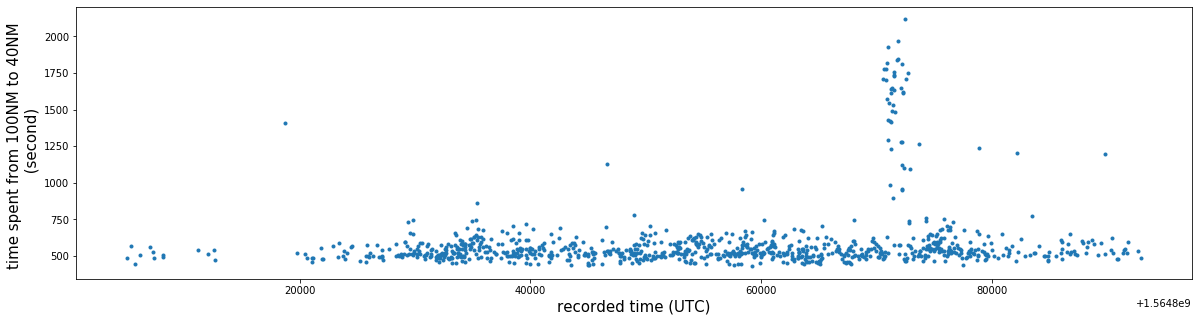

In [38]:
fig, ax = plt.subplots(figsize=(20,5))
test_arr_t = test_data['arr_time'].values
test_time_list = test_data['recTime'].values
plt.scatter(test_time_list, test_arr_t, marker='.')
plt.xlabel('recorded time (UTC)', fontsize=15)
plt.ylabel('time spent from 100NM to 40NM \n (second)', fontsize=15)

In [39]:
train_data = pdf3.drop(test_data.index)
train_data = train_data.sample(frac=1)

Text(0, 0.5, 'time spent from 100NM to 40NM \n (second)')

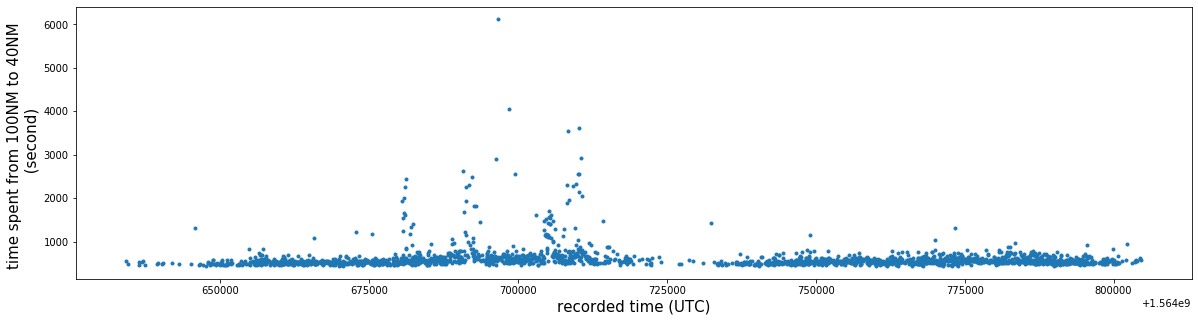

In [40]:
fig, ax = plt.subplots(figsize=(20,5))
arr_t = train_data['arr_time'].values
time_list = train_data['recTime'].values
plt.scatter(time_list, arr_t, marker='.')
plt.xlabel('recorded time (UTC)', fontsize=15)
plt.ylabel('time spent from 100NM to 40NM \n (second)', fontsize=15)
#fig.savefig('arrival_time')

In [41]:
test_data = test_data.loc[test_data['Dest']=='KATL']

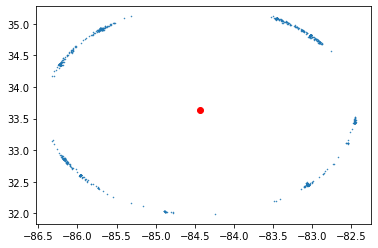

In [42]:
plt.scatter(test_data['lon'].values, test_data['lat'], marker='.', s=1)
plt.scatter(airportsCoord['KATL'][1], airportsCoord['KATL'][0], color='r')

# Prediction

## Random Forest Method

In [43]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.8" 2020-07-14; OpenJDK Runtime Environment AdoptOpenJDK (build 11.0.8+10); OpenJDK 64-Bit Server VM AdoptOpenJDK (build 11.0.8+10, mixed mode)
  Starting server from /home/pzhao28/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpfcb60ynd
  JVM stdout: /tmp/tmpfcb60ynd/h2o_pzhao28_started_from_python.out
  JVM stderr: /tmp/tmpfcb60ynd/h2o_pzhao28_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Phoenix
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,2 months and 22 days
H2O_cluster_name:,H2O_from_python_pzhao28_a1b7ey
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.836 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [44]:
hf = h2o.H2OFrame(train_data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [45]:
predictors = ['hour', 'lat', 'lon', 'alt', 'Dest','distance', 'acType', 'groundSpeed', 'num_ac_ahead', 'num_ac_behind','distance']
#response = "arr_time"
response = "holding"

# split into train and validation sets
train, valid = hf.split_frame(ratios = [.8], seed = 1234)

# train a GBM model
ac_gbm = H2OGradientBoostingEstimator(distribution = "gaussian", seed = 1234)
ac_gbm.train(x = predictors,
               y = response,
               training_frame = train,
               validation_frame = valid)

# retrieve the model performance
perf = ac_gbm.model_performance(valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [46]:
pred = ac_gbm.predict(valid)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [47]:
pred

predict
0.00316383
0.0709428
0.0688622
0.0592535
0.0235338
0.126945
0.0817484
0.021564
0.00300166
0.0295213


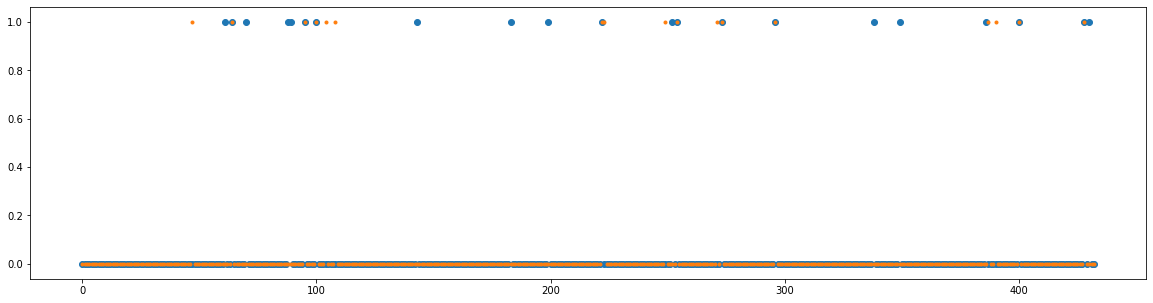

In [53]:
fig, ax = plt.subplots(figsize=(20,5))
validpd = h2o.as_list(valid)
x = np.arange(len(validpd))
plt.scatter(x,validpd['holding'].tolist())
predpd = h2o.as_list(pred)
predpd[predpd['predict']>0.2]=1
predpd[predpd['predict']<=0.2]=0
plt.scatter(x,predpd['predict'].tolist(), marker='.')

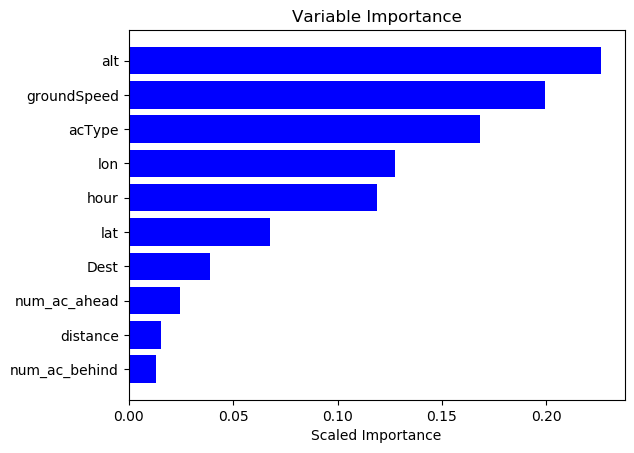

In [46]:
plt.rcdefaults()
fig, ax = plt.subplots()
variables = ac_gbm._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = ac_gbm._model_json['output']['variable_importances']['percentage']
ax.barh(y_pos, scaled_importance, align='center', color='blue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

In [47]:
ac_gbm.varimp(True)

,variable,relative_importance,scaled_importance,percentage
0,alt,114299664.0,1.000000,0.226101
1,groundSpeed,100714312.0,0.881143,0.199228
2,acType,85073272.0,0.744300,0.168287
3,lon,64402544.0,0.563453,0.127398
4,hour,60206916.0,0.526746,0.119098
5,lat,34208188.0,0.299285,0.067669
6,Dest,19767060.0,0.172941,0.039102
7,num_ac_ahead,12532521.0,0.109646,0.024791
8,distance,7776621.0,0.068037,0.015383
9,num_ac_behind,6542647.0,0.057241,0.012942


In [48]:
ac_gbm.rmse

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1608322595129_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,12432.0,5.0,5.0,5.0,8.0,21.0,12.58




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 33500.70065836821
RMSE: 183.03196622002454
MAE: 70.72363068138421
RMSLE: 0.15161502192652324
Mean Residual Deviance: 33500.70065836821

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 28533.75368239356
RMSE: 168.91937035874116
MAE: 84.49951255791287
RMSLE: 0.1932748423895609
Mean Residual Deviance: 28533.75368239356

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2020-12-18 13:46:31,0.124 sec,0.0,295.228120,120.676997,87159.642852,184.881780,101.936701,34181.272442
1,,2020-12-18 13:46:31,0.385 sec,1.0,285.658933,115.533111,81601.026201,180.353992,97.892195,32527.562565
2,,2020-12-18 13:46:31,0.441 sec,2.0,277.946184,111.916939,77254.081032,177.931406,96.451258,31659.585350
3,,2020-12-18 13:46:32,0.470 sec,3.0,271.600961,108.105764,73767.081906,174.065708,94.553986,30298.870799
4,,2020-12-18 13:46:32,0.493 sec,4.0,264.606212,104.637256,70016.447401,172.267580,92.777910,29676.119114
5,,2020-12-18 13:46:32,0.512 sec,5.0,260.041958,101.836935,67621.820169,171.251104,92.077244,29326.940572
6,,2020-12-18 13:46:32,0.531 sec,6.0,254.458032,98.227592,64748.889965,169.072347,89.981853,28585.458669
7,,2020-12-18 13:46:32,0.554 sec,7.0,250.003056,95.672773,62501.528013,167.864473,88.493547,28178.481363
8,,2020-12-18 13:46:32,0.569 sec,8.0,246.493878,93.540052,60759.231701,169.136777,87.868503,28607.249414
9,,2020-12-18 13:46:32,0.596 sec,9.0,242.878847,91.730839,58990.134188,169.079456,86.744810,28587.862512



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,alt,114299664.0,1.000000,0.226101
1,groundSpeed,100714312.0,0.881143,0.199228
2,acType,85073272.0,0.744300,0.168287
3,lon,64402544.0,0.563453,0.127398
4,hour,60206916.0,0.526746,0.119098
5,lat,34208188.0,0.299285,0.067669
6,Dest,19767060.0,0.172941,0.039102
7,num_ac_ahead,12532521.0,0.109646,0.024791
8,distance,7776621.0,0.068037,0.015383
9,num_ac_behind,6542647.0,0.057241,0.012942


<bound method ModelBase.rmse of >

## Quantile Regression Forests Method

In [49]:
hf = h2o.H2OFrame(train_data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [50]:
predictors = ['hour', 'lat', 'lon', 'alt', 'Dest', 'acType', 'groundSpeed', 'num_ac_ahead', 'num_ac_behind','distance']
response = "arr_time"

# split into train and validation sets
train, valid = hf.split_frame(ratios = [.8], seed = 1234)
# train a GBM model
ac_gbm_low = H2OGradientBoostingEstimator(distribution = "quantile",quantile_alpha = 0.164, seed = 1234)
ac_gbm_low.train(x = predictors,
               y = response,
               training_frame = train,
               validation_frame = valid)

#print(ac_gbm.predict(valid))

# retrieve the model performance
#perf = ac_gbm.model_performance(valid)
pred_low = ac_gbm_low.predict(valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


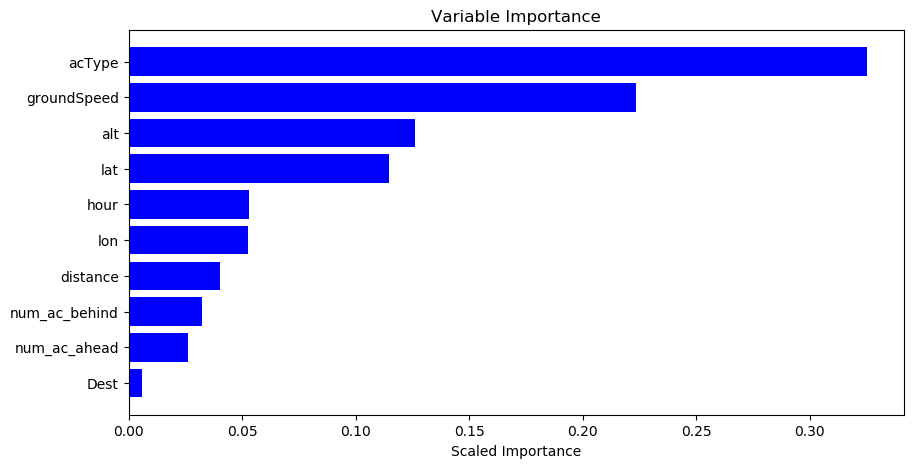

In [51]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,5))
variables = ac_gbm_low._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = ac_gbm_low._model_json['output']['variable_importances']['percentage']
ax.barh(y_pos, scaled_importance, align='center', color='blue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()


In [52]:
ac_gbm_up = H2OGradientBoostingEstimator(distribution = "quantile",quantile_alpha = 0.837, seed = 1234)
ac_gbm_up.train(x = predictors,
               y = response,
               training_frame = train,
               validation_frame = valid)

#print(ac_gbm.predict(valid))

# retrieve the model performance
#perf = ac_gbm.model_performance(valid)
pred_up = ac_gbm_up.predict(valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


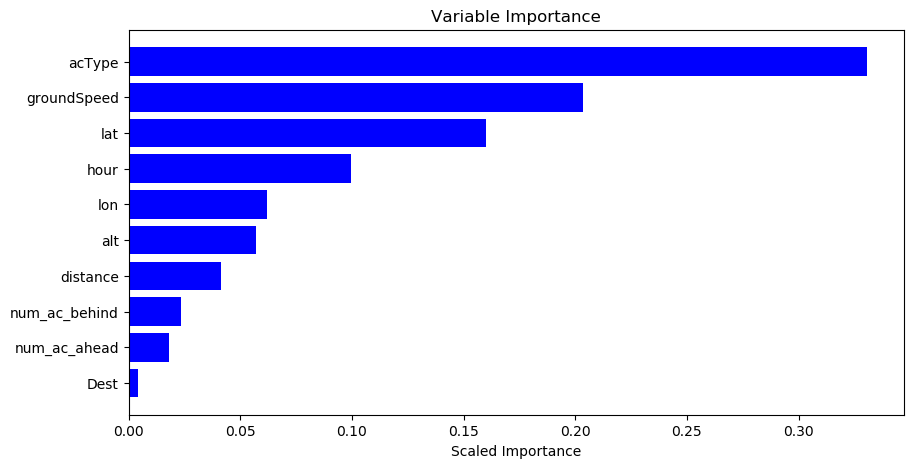

In [53]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,5))
variables = ac_gbm_up._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = ac_gbm_up._model_json['output']['variable_importances']['percentage']
ax.barh(y_pos, scaled_importance, align='center', color='blue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()


Text(0.5, 0, 'Data Number')

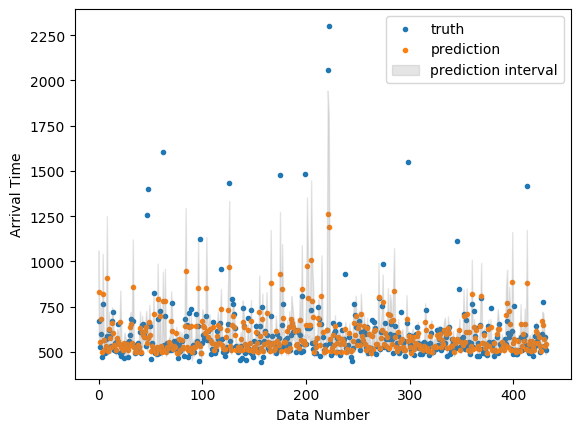

In [54]:
fig, ax= plt.subplots()
validpd = h2o.as_list(valid)
_ = range(valid.shape[0])
plt.scatter(_,validpd['arr_time'].tolist(), marker = '.', label='truth')

err_low = np.array(h2o.as_list(pred_low)['predict'])
err_up = np.array(h2o.as_list(pred_up)['predict'])

pred_m = (err_low+err_up)*0.5
_ = range(len(pred_m))
yerror = [err_low - pred_m, err_up-pred_m]
plt.scatter(_,pred_m, marker = '.', label='prediction')
#plt.errorbar(_, pred_new, yerr=yerror, fmt='k', elinewidth=None, capsize=5, barsabove=False, ls='none')
plt.fill_between(x, err_low, err_up, color='gray', alpha=0.2, label='prediction interval')
plt.legend()
plt.ylabel('Arrival Time')
plt.xlabel('Data Number')


# Implementation

In [55]:
from pyomo.environ import *
import numpy as np
import sys
from DistributionATSP import Distribution_ATSP
from scipy.stats import norm
import matplotlib.pyplot as plt
import random as rd
import pandas as pd

### Separate data with different runways

In [56]:
runway1 = [33.64,33.65]
runway2 = [33.63,33.64]
runway3 = [33.62,33.63]
ac_runway1 = []
ac_runway2 = []
ac_runway3 = []
for index, row in test_data.iterrows():
    acTr = pdf_rec3.loc[pdf_rec3['acId']==row['acId']]
    end_row = acTr.loc[acTr['end_ac']==True]
    check1 = end_row.loc[end_row['lat'].between(runway1[0], runway1[1])]
    check1 = check1.loc[check1['recTime'].between(test_init, test_init+90000)]
    if not check1.empty:
        ac_runway1.append(row['acId'])
        continue
    check2 = end_row.loc[end_row['lat'].between(runway2[0], runway2[1])]
    check2 = check2.loc[check2['recTime'].between(test_init, test_init+90000)]
    if not check2.empty:
        ac_runway2.append(row['acId'])
        continue
    check3 = end_row.loc[end_row['lat'].between(runway3[0], runway3[1])]
    check3 = check3.loc[check3['recTime'].between(test_init, test_init+90000)]
    if not check3.empty:
        ac_runway3.append(row['acId'])
        continue
    
    
    #check = end_row.loc[end_row['lat'].between(runway1[0], runway1[1])]
    #check = check.loc[check['recTime'].between(test_init, test_init+90000)]
    #if check.empty:
    #    continue
    #ac_runway1.append(row['acId'])

In [57]:
test_data_runway1 = test_data[test_data['acId'].isin(ac_runway1)]
test_data_runway2 = test_data[test_data['acId'].isin(ac_runway2)]
test_data_runway3 = test_data[test_data['acId'].isin(ac_runway3)]

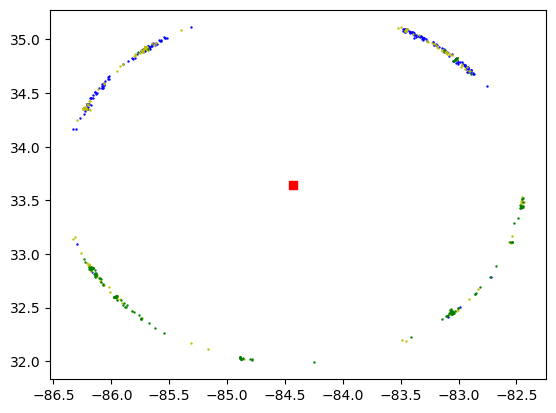

In [58]:
plt.scatter(test_data_runway1['lon'], test_data_runway1['lat'], marker='.', color='b', s=2)
plt.scatter(test_data_runway2['lon'], test_data_runway2['lat'], marker='.', color='y', s=2)
plt.scatter(test_data_runway3['lon'], test_data_runway3['lat'], marker='.', color='g', s=2)
plt.scatter(airportsCoord['KATL'][1], airportsCoord['KATL'][0], marker='s', color='r')

## landing scheduling for each runway

In [59]:
def time_space(threshold, sd1, sd2, Pc):
    return threshold - norm.ppf(q = Pc, loc = 0,scale = np.sqrt(sd1**2 + sd2**2))

In [60]:
items = ['acId', 'threshold', 'mean', 'sd', 'uperBound', 'lowerBound', 'time_init']

In [61]:
def sequence(ac,Pc=0.1):
    UB = [100000]
    LB = [0]
    tt = np.array([0])
    tt = np.append(tt, np.array(ac['mean'].tolist()))
    num_ac = len(ac)
    for index, row in ac.iterrows():
        LB.append(row['lowerBound'])
        UB.append(row['uperBound'])
        tt_temp = [0]
        for ii in ac.index:
            if index == ii:
                space = 0
            else:
                space = time_space(row['threshold'], row['sd'], ac.loc[ii]['sd'], Pc) 
            tt_temp.append(space)
        tt=np.vstack((tt, np.array(tt_temp)))
    N = num_ac
    ccc = Distribution_ATSP(UB, LB, N, tt)
    model = ccc.set_model()

    solver = SolverFactory('glpk')
    solution = solver.solve(model, tee=True)
    result_time = np.zeros(N)
    for i in range(N):
        result_time[i] = model.t[i+2].value
    sort_index = np.argsort(result_time)
    sort_time = np.sort(result_time)
    return sort_index, sort_time

In [62]:
from IPython.core.debugger import set_trace

In [77]:
result = []
result_time = []
group_num = []
start = test_data_runway1.head(1).recTime.values[0]
while start < test_data_runway1.tail(1).recTime.values[0]:
    end = start + 500
    ac = pd.DataFrame([], columns=items)
    group = test_data_runway1[test_data_runway1['recTime'].between(start-0.1, end)]
    #set_trace()
    if group.empty:
        start = end
        continue
    group_hf = h2o.H2OFrame(group)
    pred_upperBound = np.array(h2o.as_list(ac_gbm_up.predict(group_hf))['predict'])
    pred_lowerBound = np.array(h2o.as_list(ac_gbm_low.predict(group_hf))['predict'])
    pred_mean = (pred_upperBound + pred_lowerBound)/2

    past_time = group['recTime'] - min(group['recTime'])
    ac['acId'] = group['acId']
    ac.loc[:,'threshold'] = 60
    ac['mean'] = np.array(pred_mean) + past_time.values
    ac['sd'] = np.array(pred_upperBound - pred_mean)
    ac['lowerBound'] = ac['mean'] -100
    ac['uperBound'] = ac['mean'] + 600
    ac['time_init'] = group['recTime']
    ac = ac.reset_index(drop=True)
    if len(pred_mean) <= 6:
        time_spent = pred_mean
    else:
        sequence_scheduled, time_scheduled = sequence(ac,0.3)
        ac = ac.reindex(sequence_scheduled)
    #test_data_runway1.drop(index = group.index)
        time_predicted = time_scheduled +  min(group['recTime'])
        time_spent = time_predicted - ac.time_init
    if time_spent.any()<0:
        set_trace()
    result_time = np.append(result_time, ac.time_init)
    result = np.append(result,time_spent)
    group_num = np.append(group_num, len(ac))
    #set_trace()
    start = end


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |███████████

+ 98422: mip =   1.055406863e+03 >=     tree is empty   0.0% (0; 59567)
INTEGER OPTIMAL SOLUTION FOUND
Time used:   8.2 secs
Memory used: 9.3 Mb (9791319 bytes)
Writing MIP solution to '/tmp/tmpoz01l83q.glpk.raw'...
289 lines were written
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |███████████████

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |███████████

Text(0, 0.5, 'time spent from 100NM to 40NM \n (second)')

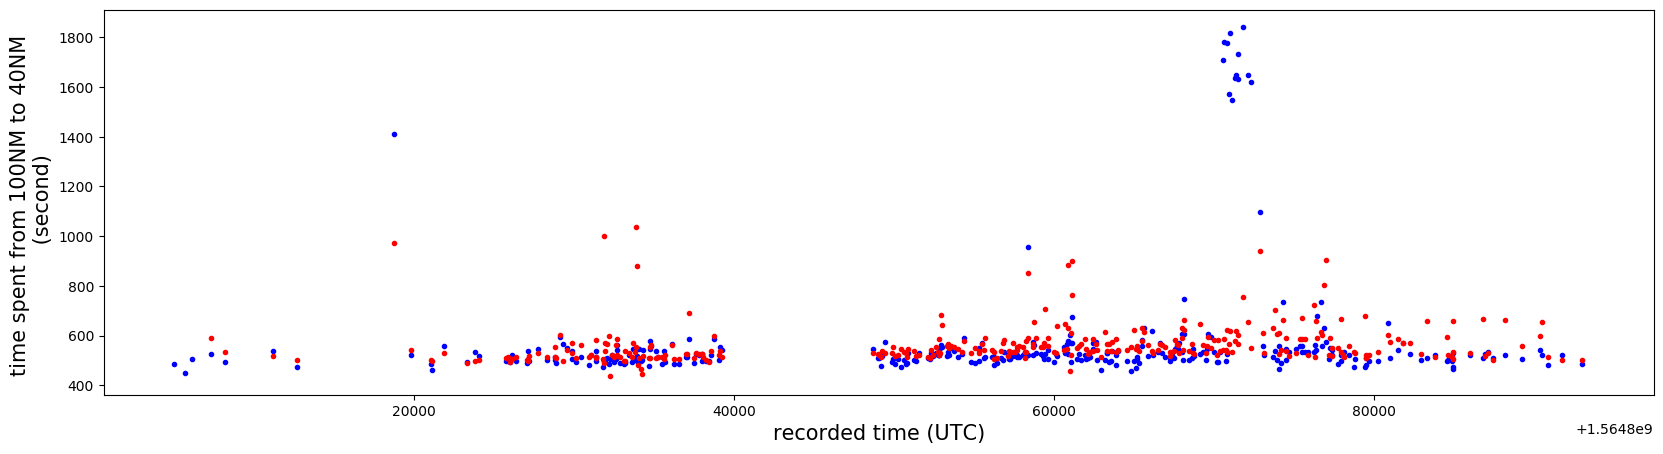

In [78]:
fig, ax = plt.subplots(figsize=(20,5))
test_arr_t = test_data_runway1['arr_time'].values
test_time_list = test_data_runway1['recTime'].values
plt.scatter(test_time_list, test_arr_t, marker='.', color='b')
plt.scatter(result_time, result, marker='.', color = 'r')
plt.xlabel('recorded time (UTC)', fontsize=15)
plt.ylabel('time spent from 100NM to 40NM \n (second)', fontsize=15)

In [65]:
len(result)

335

In [66]:
len(test_arr_t)

338

In [67]:
test_data_runway1.head(1).recTime.values[0]

1564807281

In [68]:
group_num

array([1., 1., 1., 1., 1., 1., 2., 1., 1., 2., 1., 3., 1., 4., 1., 2., 3.,
       2., 3., 1., 2., 3., 8., 5., 4., 3., 8., 4., 3., 3., 2., 1., 3., 2.,
       5., 3., 3., 1., 4., 1., 4., 3., 3., 2., 2., 5., 4., 5., 2., 2., 1.,
       5., 3., 2., 5., 5., 6., 5., 2., 5., 3., 2., 8., 3., 4., 4., 2., 5.,
       3., 2., 5., 3., 3., 3., 3., 5., 6., 4., 2., 3., 4., 4., 5., 4., 3.,
       3., 1., 6., 3., 1., 4., 2., 5., 4., 3., 4., 2., 1., 4., 1., 2., 1.,
       2., 1., 2., 2., 4., 1., 3., 1., 1., 1., 2., 1., 1., 1.])